# Natural Language Processing

### Deep Learning for Sequence Processing
<br><br>
Prof. Iacopo Masi and Prof. Stefano Faralli

In [2]:
import matplotlib.pyplot as plt
import scipy
import random
import numpy as np
import pandas as pd
pd.set_option('display.colheader_justify', 'center')

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

## My own latex definitions

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bxt#1{\mbf{x}_{\text{#1}}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$
$$\def\chain#1#2{\frac{\partial #1}{\partial #2}}$$
$$\def\loss{\mathcal{L}}$$
$$\def\params{\bmf{\theta}}$$


# Today's lecture
## - Recap on Language Models
### - From Feedforward Nets to Recurrent Neural Nets (RNN)
### - RNN Application: Parts of Speech (POS) as Sequence Labeling
## - RNN Application: Text Generation as Autoregressive model

# This lecture material is taken from
📘 **Chapter 9 Jurafsky Book**

📘 **Chapter 6.3 Eisenstein Book**
- [Stanford Slide RNN](http://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture05-rnnlm.pdf)
- [Stanford Lecture RNN](https://www.youtube.com/watch?v=0LixFSa7yts&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=6)
- [Stanford Notes on Word2Vec](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes05-LM_RNN.pdf)
- [Andrej Karpathy Lecture on RNN](https://www.youtube.com/watch?v=yCC09vCHzF8)
- [Andrej Karpathy Slides on RNN](http://cs231n.stanford.edu/slides/2022/lecture_10_ruohan.pdf)

Another resource with code is [[d2l.ai] RNN](https://d2l.ai/chapter_recurrent-neural-networks/index.html)

# Deep Learning for Sequence Processing

# Language Model (LM)

**Language Modeling (LM)** is the task of predicting what word comes next:

> the students opened their _________

books, laptops, exams, minds?

# Language Model: the order matters!

> the cat is small

| 0   | 1   | 2  | 3     |
|-----|-----|----|-------|
| the | cat | is | small |

$$p(\text{the}, \text{cat}, \text{is}, \text{small}) = 0.035$$

>small the is cat

| 0     | 1   | 2   | 3  |
|-------|-----|-----|----|
| small | the | cat | is |

$$p(\text{small}, \text{the}, \text{cat}, \text{is}) = 0.000001$$

# Language Model (LM)
More formally, given a sequence of words $w_1,\ldots,w_t$, compute the probabilities distributions over the text words $w_{t+1}$ where the support of the probability is a vocabulary $V$.

$$ p(w_{t+1}|w_t,\ldots,w_1)$$

where $w_{t+1}$ can be any word in $V = \{w_1,\ldots,_{|V|}\}$

A system that does this is called a **Language Model**

# Language Model (LM)

You can also think a LM as a **machinery that assign a probability to a piece of text of T words:**

$$ p(w_t,\ldots,w_1) = \underbrace{p(w_t,\ldots,w_2|w_1)}_{\text{recursion}} \cdot \underbrace{p(w_1)}_{\text{base case}}$$

$$ = p(w_t,\ldots,w_2|w_1) \cdot p(w_1) = p(w_t,\ldots,w_3|w_1,w_2)\cdot p(w_2|w_1) \cdot p(w_1) $$

$$= p(w_t,\ldots,w_3|w_1,w_2)\cdot p(w_2|w_1) \cdot p(w_1) = \prod_{t=2}^N p(w_{t}|w_{t-1},\ldots,w_1) \cdot p(w_1)$$

# LM can be interpreted as an Autoregressive Model

Such models that regress the value of a signal **on the previous values of that same signal** are naturally called **autoregressive models.**

$$ p(w_{t+1}|w_t,\ldots,w_1)$$

# What LM can do

$$ p(w_{t+1}|w_t,\ldots,w_1)$$

Language models prove useful for all sorts of reasons. 

- Evaluate the the **likelihood of sentences**
    - For example, we might wish to compare the naturalness of two candidate outputs generated by a machine translation system or by a speech recognition system. 
- Ability to sample sequences, and even to optimize for the most likely sequences. Act as **Generators**.
- LM are not **ONLY generators (samplers!)** yet are statistical tools that models joint density of words where word order matters.

# Language Model: the order matters!

> the cat is small

| 0   | 1   | 2  | 3     |
|-----|-----|----|-------|
| the | cat | is | small |

$$p(\text{the}, \text{cat}, \text{is}, \text{small}) = 0.635$$

>small the is cat

| 0     | 1   | 2   | 3  |
|-------|-----|-----|----|
| small | the | cat | is |

$$p(\text{the}, \text{cat}, \text{is}, \text{small}) = 0.0034$$

# A fixed-window Neural LM (Markovian Assumption)

$$ p(w_{t+1}|w_t,\ldots,w_1) \approx p(w_{t+1}|w_t,\ldots,w_{t-N})$$

The length of the context $N$ impacts the LM!

# The Length of the Context matters! (Markovian Assumption)

**Language Modeling (LM)** is the task of predicting what word comes next:

> the students opened their _________

What is your prediction here?

> As the proctor started the clock, the students opened their _________

What is your prediction here?

# A fixed-window Neural LM

<br><div align='center'><img src="figs/feedfNN.png" width='60%' ></div>

# A fixed-window Neural LM

✅ Improvements over n-gram LM 
- No sparsity problem
- No need to store all observed n-grams!

❌ Remaining problems:
- Fixed window is too small
- Enlarging window enlarges $\mbf{W}$
- Window can never be large enough!
- No symmetry in how the inputs are processed.

# Sequence Modeling till now
<div align='center'><img src="figs/one_to_one.png" width='10%' ></div>

# Sequence Modeling: where we want to go

<div align='center'><img src="figs/one_many_to_one.png" width='40%' ></div>

# Sequence Modeling

<div align='center'><img src="figs/many_to_one.png?1" width='20%' ></div>

# Recurrent Neural Networks (RNN) for NLP

# RNN: basic principle

- We still use Markovian assumption to consider only $N$ previous steps in time
- Yet we do not model explicitly $p(w_t \mid w_{t-1}, \ldots, w_{t-N+1})$, instead we use a **latent variable model:**

$$p(w_t \mid w_{t-1}, \ldots, w_1) \approx p(w_t \mid \mbf{h}_{t-1}),$$

where $\mbf{h}_{t-1}$ is a hidden state that **"summarizes"** the sequence information up to time step $t-1$ . 

# RNN: hidden state

$$p(w_t \mid w_{t-1}, \ldots, w_1) \approx p(w_t \mid \mbf{h}_{t-1}),$$

where $\mbf{h}_{t-1}$ is a *hidden state* that stores the sequence
information up to time step $t-1$. 

In general, the hidden state at
any time step $t$ could be computed based on both the current
input $w_{t}$ and the previous hidden state $\mbf{h}_{t-1}$:

$$ \mbf{h}_t = f(w_{t}, \mbf{h}_{t-1}) $$

Informal: think $\mbf{h}_{t}$ as a sort of memory of what happened so far up to $t-1$ plus the current input $w_t$.

# Hidden layer vs Hidden states

Recall that we have discussed hidden layers with hidden units in **window-based Neural LM.** 

It is noteworthy that hidden layers and hidden states refer to two very different concepts. 

- Hidden layers are, as explained, layers that are hidden from view on the path from input to output. 

- Hidden states are technically speaking *inputs* to whatever we do at a given step, and they can only be computed by looking at data at previous time steps.

# Sequence Modeling

<div align='center'><img src="figs/many_to_one_01.png?4" width='20%' ></div>

# How do we implement $ f(w_{t}, \mbf{h}_{t-1}) $ ?

Assume $\mbf{e}_t$ is the word embedding of word token at time $t$ and $w_t$ corresponds to the one-hot encoding of the word, as $\mbf{e}_t=\bmf{\theta}w_t$. Then:

$$f(w_{t}, \mbf{h}_{t-1}) \doteq \sigma \big( \mbf{W}_h\mbf{h}_{t-1}+ \mbf{W}_e\mbf{e}_{t} +\mbf{b}\big)$$

This formulation is called **Elman Networks [Elman, 1990] or simple recurrent neural networks**.

# How do we implement $ f(w_{t}, \mbf{h}_{t-1}) $ ?

Assume $\mbf{e}_t$ is the word embedding of word token at time $t$ and $w_t$ corresponds to the one-hot encoding of the word, as $\mbf{e}_t=\bmf{\theta}w_t$. Then:

$$f(w_{t}, \mbf{h}_{t-1}) \doteq \sigma \big( \underbrace{\mbf{W}_h\mbf{h}_{t-1}}_{\text{from prev. steps}}+ \underbrace{\mbf{W}_e\mbf{e}_{t}}_{\text{current input}} +\mbf{b}\big)$$

where $\sigma(\cdot)$ is a non-linear activation function such as _hyperbolic tan or sigmoid_.

# Sequence Modeling: something is missing here
## Can you spot what?

<div align='center'><img src="figs/many_to_one_01.png?4" width='15%' ></div>

# Sequence Modeling: something is missing here
## Can you spot what? The base case: Starting hidden state!

<div align='center'><img src="figs/many_to_one_02.png?4" width='20%' ></div>

# Sequence Modeling: Something is missing here, can you spot what?

You need the "base case", the starting hidden state, usually $\mbf{h}_0$ is set to all zeros.

<div align='center'><img src="figs/many_to_one_02.png?4" width='25%' ></div>

# What happens at each time step

Note: Bias omitted for simplicity

<br><div align='center'><img src="figs/many_to_one_03.png?4" width='30%' ></div>

# What happens at each time step

Note: Bias omitted for simplicity

<br><div align='center'><img src="figs/many_to_one_04.png?5" width='50%' ></div>

# The weights are always the same!

Note: Bias omitted for simplicity

<br><div align='center'><img src="figs/many_to_one_05.png?1" width='50%' ></div>

# $\mbf{W}_e$ and $\mbf{W}_h$ do NOT depend on $t$!

$$\mbf{h}_{t} \doteq \sigma \big( \underbrace{\mbf{W}_h\mbf{h}_{t-1}}_{\text{from prev. steps}}+ \underbrace{\mbf{W}_e\mbf{e}_{t}}_{\text{current input}} +\mbf{b}\big)$$

**Good Scalability:** for space complexity. 

The model scales w.r.t to the time dimension, so **we can allow our context to be long**!

# From the hidden state to an output

$$\mbf{h}_{t} \doteq \sigma \big( \underbrace{\mbf{W}_h\mbf{h}_{t-1}}_{\text{from prev. steps}}+ \underbrace{\mbf{W}_e\mbf{e}_{t}}_{\text{current input}} +\mbf{b}\big)$$

$$ \mathbf{y}_t= \operatorname{softmax}(\mbf{U}\bmf{h}_t+\mbf{b}_2)$$

# Dynamics vs what we really store in memory

Therefore, the parameterization cost of an RNN does not grow as the number of time steps increases.

<br><div align='center'><img src="figs/many_to_one_06.png?1" width='50%' ></div>

# Implementation detail

$$\mbf{h}_{t} \doteq \sigma \big( \underbrace{\mbf{W}_h\mbf{h}_{t-1}}_{\text{from prev. steps}}+ \underbrace{\mbf{W}_e\mbf{e}_{t}}_{\text{current input}} +\mbf{b}\big)$$

Can be implemented as **fully-connected layer** matrix multiplication using concatenation:

$$\mbf{h}_{t} \doteq\sigma \big([\mbf{W}_h;\mbf{W}_e][\mbf{h}_{t-1};\mbf{e_t}]+\mbf{b}\big)$$

# RNN Forward pass in pseudo code


```python
# input x (the sequence of tokens)
h[0] = zeros # H is an array of all zeros!
for i in range(1, len(x)): # unroll the RNN in time (this is the slow part)
    h[i] = sigma(W_h@h[i-1] + W_e@e[i] + b_1)  # W_h and W_e shared across time
    y[i] = softmax(U@h[i] + b_2)               # h[i], y[i] are time dependent
```

# RNN as a Neural Language Model

The RNN as LM models $p(w_t | \text{the, students, opened ,their})$.


<div align='center'><img src="figs/rnn_lm.png" width='30%' ></div>

# RNN as a Neural Language Model

The RNN models $p(w_5 | \text{the, students, opened ,their})$.

<div align='center'><img src="figs/rnn_glance.png" width='65%' ></div>

# RNN  Language Model


✅ Improvements over window-based LM 
- Can process any length input
- Computation for step $t$ can **(in theory)** use information from many steps back
- Bounded model size respect to context size
- Same weights applied on every timestep, so there is symmetry in how inputs are processed.

❌ Remaining problems:
- Recurrent computation is slow (unroll in time)
- In practice, difficult to access information from many steps back

<div align='center'><img src="figs/rnn_lm.png" width='70%' ></div>

# Training a RNN Language Model

# RNN LM is many-to-many

### Sequence to Sequence modeling

<div align='center'><img src="figs/many_to_many.png" width='25%' ></div>

# RNN LM is many-to-many

- The most "stupid" sequence to sequence modeling is the **identity function of the data**
- The simplest yet useless way to generate the data is propagate the data itself
- You can think this also as a form of **memorization (overfitting)** compared to learning.

<center>
<h3>LM : NLP = Generative Models : Vision</h3>
</center>

<br>
<div align='center'><img src="figs/many_to_many_id.png" width='35%' ></div>

# RNN LM is many-to-many

### Sequence to Sequence modeling

<div align='center'><img src="figs/many_to_many.png" width='25%' ></div>

# Recurrency (Bad Visualization)

<div align='center'><img src="figs/recurrency.png" width='10%' ></div>

# Recurrency (Bad Visualization)

In theory, recurrency with cycles is a problem for training, but we can show that we can **unfold the RNN over time and still create a DAG.**

<br/><div align='center'><img src="figs/recurrency.png" width='10%' ></div>

# Unfolding the recurrency over time

Explicitly **unrolling a recurrent network into a feedforward computational graph** eliminates any explicit recurrences, allowing the network weights to be trained directly.

**The step of unfolding** is an hyper-param that you have to decide.
<div align='center'><img src="figs/recurrency_unfold.png" width='25%' ></div>

# Training a RNN Language Model

- Get a big corpus of text which is a sequence of words $\{w_1,\ldots,w_N\}$
- Feed a window till time $t$ to the RNN-LM, compute probability distribution over $V$ at time $t+1$
    - Predict a probability distribution $\hat{\mbf{y}}$ over words, given words so far
- Loss function is same as word2vec: we compare two discrete distributions with **cross-entropy**
$$ \loss(\{\mbf{W}\}) = CE(\hat{\mbf{y}},{\mbf{y}})= -\sum_{w\in V}\mbf{y}\log(\hat{\mbf{y}}) =-\log(\hat{\mbf{y}})[t+1]$$

- **Note:** $[t+1]$ selects the index in $V$ of the next word, at time $t+1$
- We use again **self supervision!**

# Training a RNN Language Model


<br/><div align='center'><img src="figs/rnn_lm_train_01.png" width='40%' ></div>

# Training a RNN Language Model


<br/><div align='center'><img src="figs/rnn_lm_train_02.png" width='40%' ></div>

# Training a RNN Language Model


<br/><div align='center'><img src="figs/rnn_lm_train_04.png" width='40%' ></div>

# Teacher Forcing at training time

**When training, <u>the autoregressive capability is turned OFF</u>**. This is is called **teacher forcing**.
At time $t=3$ the model predicts `zoom` but the word should have been `their`. 

As input to time $t=3$ we use the value from the corpus `their` NOT the prediction `zoom`.
<div align='center'><img src="figs/rnn_lm_train_05.png?1" width='30%' ></div>

# Training a RNN Language Model

- Computing the loss and gradients across the entire corpus $\{w_1,\ldots,w_N\}$ is too expensive
    - We would do a simple GD update after seeing the entire corpus!
    - So we use an approximation using SGD. 
    - We consider $\{w_1,\ldots,w_N\}$ as **a sentence or a document but not the entire corpus.**
    $$\frac{1}{T}\sum_{t=1}^T\mathcal{L}_t(\bmf{\theta}) $$
    
- SGD allows us to compute loss and gradients for a small chunk of text, and then update the model.

# Training a RNN Language Model
1. Compute the loss for a sentence (Note: in the implementation is a batch of sentence)
2. **Compute the gradients on weights** (Most difficult part to understand 🔥)
3. Update the weights
4. Get another batch of sentences and repeat.

# How do we get the gradients on the weights?

# We use Back Propagation Through Time (BPTT)

# Back Propagation Through Time (BPTT)

We can approach BPTT:
1) using the computational graph _(engineering point of view/intuition)_
2) mathematically _(more formal, gives a motivation)_

# Forward pass in RNN
<div align='center'><img src="figs/rnn_backprop/Slide45.png" width='70%' ></div>

# Forward pass in RNN
<div align='center'><img src="figs/rnn_backprop/Slide46.png" width='70%' ></div>



# Forward pass in RNN
<div align='center'><img src="figs/rnn_backprop/Slide47.png" width='70%' ></div>



# Forward pass in RNN
<div align='center'><img src="figs/rnn_backprop/Slide48.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward
<div align='center'><img src="figs/rnn_backprop/Slide49.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward
<div align='center'><img src="figs/rnn_backprop/Slide50.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward
<div align='center'><img src="figs/rnn_backprop/Slide51.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward
<div align='center'><img src="figs/rnn_backprop/Slide52.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward

Eventually we will arrive to **receive gradients on weights.**

Remember at each time step: $F_w$ received different inputs yet the **parameters $\mbf{W}_h$ are the <u>same across time.<u/>**
<div align='center'><img src="figs/rnn_backprop/Slide54.png" width='70%' ></div>



# Back Propagation Through Time (BPTT) - Backward

Eventually we will arrive to receive gradients on weights.

Remember at each time step: $F_w$ received different inputs yet the **parameters $\mbf{W}_h$ are the <u>same across time.<u/>**
<div align='center'><img src="figs/rnn_backprop/Slide55.png" width=70%' ></div>



# Gradients sum at outward branches

$\mbf{h_3}$ is input to <u>two functions</u> "in the future": one produce $\mbf{y}_3$ the other will produce $\mbf{h}_4$.

So $\mbf{h_3}$ will receive **two** gradients that will <u>be summed together</u>.

<div align='center'><img src="figs/rnn_backprop/Slide56.png" width='15%' ></div>

# Gradients sum at outward branches

$$ \chain{f\big(x(t),y(t)\big)}{t}  = \chain{f}{x}\chain{x}{t}+\chain{f}{y}\chain{y}{t}$$
<br>
<div align='center'><img src="figs/rnn_backprop/Slide57.png" width='15%' ></div>

# Back Propagation Through Time (BPTT)

Mathematically: **apply chain rule**. Note: I simplified by NOT showing:
- the biases
- the weights that transform the input $\mbf{W}_e$ and the weights that do classification at each output $\mbf{U}$.
- Keep in mind that we have to receive gradients over them because we need to update them as well

I do show the weights $\mbf{W}_h$, because **this is the hardest part of BPTT.**

It is the part in which we have the recursion, and we really go "back in time".

# Back Propagation Through Time (BPTT)

Let's first agree on what we have to compute:

 $$\chain{\loss}{\mbf{W}_h} =~~? \qquad \text{we use chain rule to compute it}$$

Note this is a function that maps a matrix $\mbf{W}_h$ to a scalar value, the loss $\loss$. 

This makes sense to compute because the loss $\loss$ depends on $\mbf{W}_h$.

We want to know what is the "infinitesimal" influence on the loss by perturbing a bit of $\mbf{W}_h$ (informal definition of gradient).

# Back Propagation Through Time (BPTT)

Let's first agree on what we have to compute:
 $$\chain{\loss}{\mbf{W}_h} =~~? \qquad \text{we use chain rule to compute it}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# Back Propagation Through Time (BPTT)

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\quad{...}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# Back Propagation Through Time (BPTT)

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\quad{...}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# Back Propagation Through Time (BPTT)

$$\chain{\loss}{\mbf{W}_h} = \underbrace{\chain{\loss}{\loss}}_1\underbrace{\chain{\loss}{\loss_3}}_{1/T=1/3}\underbrace{\chain{\loss_3}{\mbf{y}_3}}_{\mathbb{R}^{1\times|V|}}\underbrace{\chain{\mbf{y}_3}{\mbf{h}_3}}_{\mathbb{R}^{|V|\times h}}\quad{...}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# Back Propagation Through Time (BPTT)

$$\chain{\loss}{\mbf{W}_h} = \underbrace{\chain{\loss}{\loss}}_1\underbrace{\chain{\loss}{\loss_3}}_{1/T=1/3}\underbrace{\chain{\loss_3}{\mbf{y}_3}}_{\mathbb{R}^{1\times|V|}}\underbrace{\chain{\mbf{y}_3}{\mbf{h}_3}}_{\mathbb{R}^{|V|\times h}}\underbrace{\chain{\mbf{h}_3}{\mbf{W}_h}}_{\mathbb{R}^{h}\times(\mathbb{R}^{h}\times \mathbb{R}^{h})}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# BPTT

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

The tricky part is $\chain{\mbf{h}_3}{\mbf{W}_h}$

$\mbf{h}_3 =f\big(\mbf{h}_2,\mbf{W}_h,...)$
 


 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=70%' ></div>

# BPTT

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

The tricky part is $\chain{\mbf{h}_3}{\mbf{W}_h}$. Remember that $\mbf{h}_3 =f\big(\mbf{h}_2,\mbf{W}_h,\mbf{W}_e,\mbf{x}_3\big)$. 

So $\mbf{h}_3$ depends on $\mbf{h}_2$!
 

# BPTT

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

$$\mbf{h}_3 =f\big(\mbf{h}_2,\mbf{W}_h,...\big)$$.
 

# BPTT and Vanishing Gradient problem

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

$$\mbf{h}_3 =f\big(\underbrace{f\big(\mbf{h}_1,\mbf{W}_h,...\big)}_{\mbf{h}_2},\mbf{W}_h,...\big)$$
 

# This is the essence of BPTT

$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

$$\mbf{h}_3 =f\big(\underbrace{f\big(\mbf{h}_1,\mbf{W}_h,...\big)}_{\mbf{h}_2},\mbf{W}_h,...\big)$$

 
<small>[If you want to go deeper d2l.ai on BPTT](https://d2l.ai/chapter_recurrent-neural-networks/bptt.html)</small>

# This is the essence of BPTT
Missing part: $$\chain{\mbf{h}_3}{\mbf{W}_h}~=~?$$

So far:
$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

$$\mbf{h}_3 =f\big(\underbrace{f\big(\mbf{h}_1,\mbf{W}_h,...\big)}_{\mbf{h}_2},\mbf{W}_h,...\big)$$

 
<small>[If you want to go deeper: d2l.ai on BPTT](https://d2l.ai/chapter_recurrent-neural-networks/bptt.html)</small>

# This is the essence of BPTT
$\def\restrict#1{\raise-.5ex\hbox{\ensuremath|}_{#1}}$

Missing part: $$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\cdot\underbrace{\chain{\mbf{h}_2}{\mbf{W}_h}}_{\text{note: another rec.}}$$

So far:
$$\chain{\loss}{\mbf{W}_h} = \chain{\loss}{\loss}\chain{\loss}{\loss_3}\chain{\loss_3}{\mbf{y}_3}\chain{\mbf{y}_3}{\mbf{h}_3}\chain{\mbf{h}_3}{\mbf{W}_h}$$

$$\mbf{h}_3 =f\big(\underbrace{f\big(\mbf{h}_1,\mbf{W}_h,...\big)}_{\mbf{h}_2},\mbf{W}_h,...\big)$$

 
<small>[If you want to go deeper: d2l.ai on BPTT](https://d2l.ai/chapter_recurrent-neural-networks/bptt.html)</small>

# BPTT

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{W}_h}$$

# BPTT

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{W}_h}$$

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\Big[\chain{\mbf{h}_2}{\mbf{W}_h}+\chain{\mbf{h}_2}{\mbf{h}_1}\chain{\mbf{h}_1}{\mbf{W}_h}\Big]$$

# BPTT

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{W}_h}$$

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\Big[\chain{\mbf{h}_2}{\mbf{W}_h}+\chain{\mbf{h}_2}{\mbf{h}_1}\chain{\mbf{h}_1}{\mbf{W}_h}\Big]$$


$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{h}_1}\chain{\mbf{h}_1}{\mbf{W}_h}$$

# Back Propagation Through Time (BPTT)

$$\chain{\loss}{\mbf{W}_h} = \underbrace{\chain{\loss}{\loss}}_1\underbrace{\chain{\loss}{\loss_3}}_{1/T=1/3}\underbrace{\chain{\loss_3}{\mbf{y}_3}}_{\mathbb{R}^{1\times|V|}}\underbrace{\chain{\mbf{y}_3}{\mbf{h}_3}}_{\mathbb{R}^{|V|\times h}}\underbrace{\chain{\mbf{h}_3}{\mbf{W}_h}}_{\mathbb{R}^{h}\times(\mathbb{R}^{h}\times \mathbb{R}^{h})}$$
 
 <div align='center'><img src="figs/rnn_backprop/Slide58.png" width=60%' ></div>

# BPTT and Vanishing Gradient Problem

If the recursive chain is too long, the produce of matrices $\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{h}_1}...$ can make the **gradient to vanish** especially if using tanh activation function.

Think as multiply $a\cdot b\cdot b\cdot b\cdot b\cdot b ...$ where $0<b<1$ but for matrices. 

**At the end the norm of the gradient will be so small that will get to zero numerically!**

$$\chain{\mbf{h}_3}{\mbf{W}_h}\Big\vert_{\text{all time steps}}=\chain{\mbf{h}_3}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{W}_h}+\chain{\mbf{h}_3}{\mbf{h}_2}\chain{\mbf{h}_2}{\mbf{h}_1}\chain{\mbf{h}_1}{\mbf{W}_h}$$



# Vanishing Gradient and RNN

- For this reason RNN **cannot capture large context dependency** in the text and they are bounded to model moderately small sequences of text. 

- Still better than window based approach.


# Vanishing Gradient and NLP

- **LM task:** `When she tried to print her tickets, she found that the printer was out of toner.
She went to the stationery store to buy more toner. It was very overpriced. After
installing the toner into the printer, she finally printed her ________`
- To learn from this training example, the RNN-LM needs to model the dependency between **“tickets” on the 7th step** and the target word “tickets” at the end.

- But if the gradient is small, the model cannot learn this dependency
- So, the model is unable to predict similar long-distance dependencies at test time

# Vanishing Gradient Workaround: Truncated BPTT

- We use SGD compute the gradients over a small windows (i.e. 25 steps) and then update the parameters.
- We avoid computing this over longer sequences.
 <div align='center'><img src="https://d2l.ai/_images/truncated-bptt.svg" width='50%' ></div>

_Comparing strategies for computing gradients in RNNs. From top to bottom: randomized truncation, regular truncation, and full computation._

# BPTT

 <div align='center'><img src="figs/BPTT_01.png" width='100%' ></div>
 
<small>picture from Stanford</small>

# Truncated BPTT

 <div align='center'><img src="figs/BPTT_02.png" width='40%' ></div>
 
<small>picture from Stanford</small>

# Truncated BPTT

 <div align='center'><img src="figs/BPTT_03.png" width='100%' ></div>
 
<small>picture from Stanford</small>

# Truncated BPTT

 <div align='center'><img src="figs/BPTT_04.png" width='100%' ></div>
 
<small>picture from Stanford</small>

# Opposite problem: Exploding gradient

- The norm of the gradient becomes to big (think as a force that is applied too strongly and abruptly).
- Machine precision cannot represent it, if too strong! You spot it if in the loss you encounter `NaN`.
- Easier problem than vanishing gradient

## Easy work around is to clip the gradient
Idea: if gradient is higher than a maximum threshold, then push it down to the maximum threshold
```python
np.clip(gradient, -5, 5, out=gradient) # clip to mitigate exploding gradients
```

# Gradient Clipping for Exploding Gradient

<br/><div align='center'><img src="figs/grad_clipping.png" width='60%' ></div>

# OK, so now that we know how to train it how do we generate text?

# Remember LM is a Autoregressive, Generative model 

# Generation from a LM - "Generating roll outs"

Equivalent to 1) generate samples from a generative model 2) use the **autoregressive** capability of the LM.

Long story short: 
1. input a base case token $\leftarrow$ Initialization
2. predict at time $t$ (now you have two choice: deterministic or probabilistic)
    - Deterministic: take `argmax` over the softmax probabilities
    - Probabilistic: we use **inverse transform sampling** to sample a word from the softmax probabilities
3. Once you sampled at time $t$, feed as input the sampled word at time $t+1$ and continue
4. The LM ends when predicts `<END>`special token.

# Inverse Transform Sampling

1. Given a discrete distribution $p$ of probabilities defined over a vocabulary $V$
2. Compute the Cumulative Density Function (CDF) of $p$ 
3. Sample uniformly in $u \sim \mathcal{U}[0,1]$ use $u$ to index inverting the (CDF)
4. According to the interval you are in, now select the word

# Inverse Transform Sampling

```python
U = np.random.rand(1000) #random sample uniformly from [0, 1]. 
# u ~ U[0,1]
# for each sampled u.
# find the first bin for which u > cumsum. 
# Get the index of that bin as the sample.
sampled_idx = np.argmin((U[:, None] > pmf.cumsum()), axis=1)
```

# Inverse Transform Sampling even simpler with just Python
```python
np.random.choice(values_to_sample, p=probability)
```

# Inverse Transform Sampling 
<br>


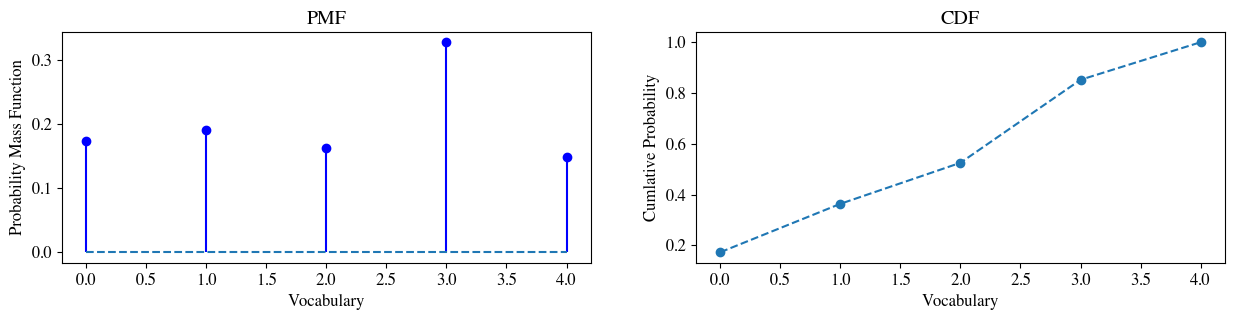

In [4]:
dist =  np.array([1.18518298, 1.30917493, 1.10973212, 2.24523519, 1.01625606])
pmf = dist/dist.sum()
fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(15)
# PDF
axs[0].stem(pmf, linefmt='b-', markerfmt='bo', basefmt='--')
axs[0].set_title('PMF')
axs[0].set_xlabel('Vocabulary')
axs[0].set_ylabel('Probability Mass Function')
axs[0].set_aspect('auto')
# CUMSUM
axs[1].plot(pmf.cumsum(), 'o--')
axs[1].set_title('CDF')
axs[1].set_xlabel('Vocabulary')
axs[1].set_ylabel('Cumlative Probability')
axs[1].set_aspect('auto')
plt.show()

# Inverse Transform Sampling in Action

<br/><center>
<img width="40%" src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Inverse_Transform_Sampling_Example.gif" /></center>

# Generation from a LM - Character-level Language Model
- The vocabulary $V$ is `[h,e,l,o]` we have learned how to say hello
- We can start from 1) <START> special token 2) or given a char as input

Long story short: **Predict + sample (if probabilistic) + autoregress**
    
   



# Generation from a LM - Character-level Language Model

<div align='center'><img src="figs/LM_sampling_01.png" width='40%' ></div>
<small>picture from Stanford</small>

# Generation from a LM - Character-level Language Model

<div align='center'><img src="figs/LM_sampling_02.png" width='40%' ></div><small>picture from Stanford</small>

# Generation from a LM - Character-level Language Model

<div align='center'><img src="figs/LM_sampling_03.png" width='40%' ></div><small>picture from Stanford</small>

# Generation from a LM - Character-level Language Model

Note that: sampling makes the generation <u>probabilistic</u>. Even if we start from the same char, we may end up with completely different words (this gives variability in the output) yet the words should match the "distribution" of the text on which was trained on. 
<div align='center'><img src="figs/LM_sampling_03.png" width='30%' ></div><small>picture from Stanford</small>

# Generation from a LM - It works with words too


<br><div align='center'><img src="figs/LM_sampling_04.png" width='50%' ></div

# LM can be seen as an Encoder Decoder

Useful idea for when we will cover **Transformers and BERT**

$$h = \operatorname{encode}(x) \quad \text{we go from x to another more useful representation h}$$

$$x^{\prime}= \operatorname{decode}(h) \quad \text{from h we can go back to an approximation of x}$$

 $$ x^{\prime}= \operatorname{decode}\big(\operatorname{encode}(x)\big)$$

# Encoder Decoder for Vision

Here $\mbf{x}$ is an image. The encoder maps the image to a low dimensional space using convolution.
<div align='center'><img src="figs/encoder_decoder_img.png" width='40%' ></div>

# LM is an Encoder Decoder for NLP

Text is Sequence to Sequence but we can decompose it as:

**Key Idea:** We decompose `Sequence to Sequence` =` Many-to-one` + `one-to-Many`

# Encoder for NLP

**Many to one:** Encode input sequence in a single vector **(e.g. the last hidden state)**


<div align='center'><img src="figs/encoder_NLP.png" width='50%' ></div>


# Encoder for NLP

**Many to one:** Encode input sequence in a single vector **(e.g. the last hidden state)**


<div align='center'><img src="figs/decoder_NLP.png" width='70%' ></div>


# Now the fun 🎉🥳
## Minimal RNN implementation in numpy in ~100 lines 


[Code from Karpathy github gist py2.7](https://gist.github.com/karpathy/d4dee566867f8291f086)

[Same but updated to py3](https://gist.github.com/karpathy/d4dee566867f8291f086)

<small>Copyright and Code by Andrej Karpathy BSD License</small>

### We will just study this for practicing, in real scenario please use [pytorch](http://pytorch.org)!

<div align='center'><img src="figs/rnn_min_code.png" width='100%' ></div>

# In practical environment: Pytorch or Pytorch Lighting!
<div align='center'><img src="https://pytorch.org/tutorials/_static/img/thumbnails/cropped/profiler.png" width='20%' ><img src="
https://assets.website-files.com/5f7852ccc906cffcb62ebb36/6010f8febaab42205eda56d0_1*JANKKXdopykNVg66IFHVVg.png" width='20%' ></div>

# RNN in 100 lines of code

It trains a RNN at the **character level** with unfolding period of *25* chars, hidden layer size is 100-D. 

We will model the input just with one-hot encoding: we will not use word embedding to keep it simple

**Requirements:** numpy only

<div align='center'><img src="https://d2l.ai/_images/rnn-train.svg" width='30%' ></div>

**Six** parts:
1. I/O: corpus parsing and vocabulary construction
2. Init of the model parameters and hyper-parameters
3. Forward pass (input to loss computation)
4. Backward pass (most complex part, Truncated BPTT) 🤯
5. Main Training Loop
6. Generation part (sampling) fun part! 🥳

# 1. I/O: corpus parsing and vocabulary construction

```python
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
```

# 2. Init of the model parameters and hyper-parameters

```python
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias
```

# 3. Forward pass

```python
def lossFun(inputs, targets, hprev):
  """
  inputs, targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
```

# 4. Back pass

```python
def lossFun(inputs, targets, hprev):
  #...
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]
    
```

# 5a. Main loop

```python
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
  # ....    
```

# 5b. Main loop

```python
  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter     
```

# 6. Generation

```python

# sample from the model now and then
sample_ix = sample(hprev, inputs[0], 200)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)

    
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes  
```

# Details on the implementation of the backward pass
[Details on the backward pass: mkffl.github.io/2019/07/08/minimalist-RNN.html](https://mkffl.github.io/2019/07/08/minimalist-RNN.html)

# RNN learns to generate Sonnets

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_01.png' width='60%' ></div>
<small>picture from Stanford</small>

# RNN learns to generate Sonnets

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_02.png' width='60%' ></div>
<small>picture from Stanford</small>

# RNN learns to generate Sonnets

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_03.png' width='60%' ></div>
<small>picture from Stanford</small>

# ...or generate Latex

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_04.png' width='60%' ></div>
<small>picture from Stanford</small>

# ...or generate Latex

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_05.png' width='60%' ></div>
<small>picture from Stanford</small>

# ...or C GNU/Linux Kernel code

<br><div align='center'><img src='figs/rnn_generation/rnn_generation_06.png' width='60%' ></div>
<small>picture from Stanford</small>

# How to evaluate a LM

# LM Evaluation (you already seen it in Part I)

- Train on `train` split.
- Select hyper-params on validation (or dev set)
- Test on the `test` split.


<div align='center'><img src="figs/validation.png" width='60%' ></div>

# Set size and partitioning: not a clear definition

<br/>

| Train              	| 70% 	| 60% 	| 80% 	|
|--------------------	|-----	|-----	|-----	|
| Validation _(dev)_ 	| 20% 	| 20% 	| 10% 	|
| Test               	| 10% 	| 20% 	| 10% 	|

# LM Evaluation Metric: Perplexity (PP)

Informally how well you predict next words on a text corpus $W$ you never trained on.
**PP the lower the better**.

$$ PP(W) \doteq p_{LM}(w_1, w_2, \ldots, w_N)^{-\frac{1}{N}} $$

$$ PP(W) = \prod_{i=1}^N \big(\frac{1}{p_{LM}(w_{i+1}|w_{i},\ldots,w_{1})} \big)^{1/N} $$

# RNNs greatly improved perplexity over prior art

Informally how well you predict next words on a text corpus $W$ you never trained on.
**PP the lower the better**.

<br><div align='center'><img src="figs/LM_evaluation_paper.png" width='70%' ></div>

<small>[Efficient softmax approximation for GPUs](https://arxiv.org/pdf/1609.04309.pdf)</small>

# Applications of Sequence Modeling, Stacked Bi-directional RNN

# OPIS for Course Evaluation

## OPIS CODE: X2YTC17W

<u>The code and guide are in the google classroom! </u>

Guide on how to evaluate with OPIS (Opinion of the students):

https://www.uniroma1.it/sites/default/files/field_file_allegati/vademecum_per_studenti_opis_2023_24_1.pdf🇮🇹

https://www.uniroma1.it/sites/default/files/field_file_allegati/guided_path_to_access_student_s_opinions_questionnaire_2022_2023.pdf 🇺🇸


# Today's lecture
## - Recap on RNN
### - We will see a few application of RNN in NLP and vision
### - Bidirectional RNN and Stacked RNN

# This lecture material is taken from
📘 **Chapter 9 Jurafsky Book**

📘 **Chapter 6.3 Eisenstein Book**
- [Stanford Slide RNN](http://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture05-rnnlm.pdf)
- [Stanford Lecture RNN](https://www.youtube.com/watch?v=0LixFSa7yts&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=6)
- [Stanford Notes on Word2Vec](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes05-LM_RNN.pdf)
- [Andrej Karpathy Lecture on RNN](https://www.youtube.com/watch?v=yCC09vCHzF8)
- [Andrej Karpathy Slides on RNN](http://cs231n.stanford.edu/slides/2022/lecture_10_ruohan.pdf)

Another resource with code is [[d2l.ai] RNN](https://d2l.ai/chapter_recurrent-neural-networks/index.html)

# Recap on RNN and LM

Language Model: A system that predicts the next word

Recurrent Neural Network: A family of neural networks that:
- Take sequential input of any length
- Apply the same weights on each step
- Can optionally produce output on each step
- Recurrent Neural Network $\neq$ Language Model

We have shown that RNNs are a great way to build a LM (despite some problems)

**RNNs are also useful for much more! We see it today!**


# Why should we care about Language Modeling

Language Modeling is a **benchmark task** that helps us measure our progress on predicting language use

Language Modeling is a subcomponent of many NLP tasks, especially those involving generating text or estimating the probability of text:
- Predictive typing
- Speech recognition
- Handwriting recognition
- Spelling/grammar correction
- Authorship identification
- Machine translation
- Summarization
- Dialogue

Everything else in NLP has now been rebuilt upon Language Modeling: GPT-3 is an LM!
Though remember that **NLP $\neq$ LM**!

# RNN can be used for...

# RNN can be used for Sequence Tagging

Solve problems such as **part-of-speech (POS) tagging, named entity recognition**

You can solve it with RNN as a many-to-many method with supervision at the word level.

<br><div align='center'><img src="figs/pos_rnn.png" width='50%' ></div>

POS is the process of assigning a part-of-speech to each word in part-of-speech tagging a text. 
**Tagging is a disambiguation task; words are ambiguous**

# Good rule for Deep Learning Researchers

**Most Frequent Class Baseline:**

> Most Frequent Class Baseline: Always compare a classifier against a baseline at
least as good as the most frequent class baseline (assigning each token to the class
it occurred most often in the training set).

# RNN can be used for Sentence Classification

Solve problems such as **sentiment classification or sentiment analysis**

You can solve it with RNN as a many-to-one method with supervision at the word level.

<br><div align='center'><img src="figs/sentiment_an_rnn.png" width='40%' ></div>

# RNN can be used for Sentence Classification

How to compute **sentence encoding?**

<br><div align='center'><img src="figs/sentiment_an_rnn.png" width='40%' ></div>

# RNN can be used for Sentence Classification

How to compute **sentence encoding?** Simple: take last hidden state vector


<br><div align='center'><img src="figs/sentiment_an_rnn_01.png?2" width='40%' ></div>

# RNN can be used for Sentence Classification

How to compute **sentence encoding?** Simple: do pooling (e.g. average) of all intermediate hidden states.


<br><div align='center'><img src="figs/sentiment_an_rnn_02.png?2" width='40%' ></div>

# RNN can be used for Encoding for other tasks

$$\mbf{x} = \operatorname{encoder}(w_1,...w_N)$$


<br><div align='center'><img src="figs/sentiment_an_rnn_02.png?2" width='40%' ></div>

# RNN can be used for Encoding for other tasks

$$\mbf{x} = \operatorname{encoder}(w_1,...w_N)$$ Useful for: **question answering, machine translation**


<br><div align='center'><img src="figs/qa_rnn_01.png?2" width='60%' ></div>

# RNN can be used for Decoding for other tasks

$$\mbf{x} = \operatorname{decoder}(\operatorname{encoder}(\text{input}),<start>)$$ 

Useful for: **speech recognition, machine translation, summarization, imagine captioning**

This is an example of a **conditional language model**. The LM is conditioned on the speech representation.

<br><div align='center'><img src="figs/speech_rnn_01.png?2" width='60%' ></div>
<small>picture from Stanford</small>

# RNN as decoder: Image Captioning

Given an image $\mbf{x}$ return a sentence that describe the image. We need:
1. Something that gets a gist representation of the image, e.g. $f(\mbf{x})$ where $f$ can be a ConvNet trained on ImageNet or with Self-Supervision.
2. Conditioned on $f(\mbf{x})$, starting from `<START>` we train an RNN to match the ground-truth sentence.
3. So we go $\mbf{x} \longrightarrow \{w_1,...,w_N\}$ 

# RNN as decoder: Image Captioning
<br><div align='center'><img src="figs/image_captioning_01.png?2" width='60%' ></div>
<small>picture from Stanford</small>

# RNN as decoder: Image Captioning
<br><div align='center'><img src="figs/image_captioning_02.png?2" width='60%' ></div>
<small>picture from Stanford</small>

# RNN as decoder: Image Captioning
<br><div align='center'><img src="figs/image_captioning_03.png?2" width='60%' ></div>
<small>picture from Stanford</small>

# RNN as Encoder: Visual Question Answering
<br><div align='center'><img src="figs/vqa_01.png" width='60%' ></div>
<small>picture from Stanford</small>

# RNN as Encoder: Visual Question Answering
<br><div align='center'><img src="figs/vqa_02.png" width='60%' ></div>
<small>picture from Stanford</small>

# Stacked Bidirectional RNN

# RNN so far

<br><div align='center'><img src="figs/stacked_rnn_01.png" width='30%' ></div>

# Stacked RNN (or Multi-layer RNN)

- RNNs are already "deep" on one dimension, **the time dimension**---they unroll over many timesteps.

- We can also make them “deep” in **another dimension** (the representation dimension)! We can do so by applying multiple RNNs – this is a multi-layer RNN (stacked RNN).

- This allows the network to compute more complex representations 

- The lower RNNs should compute lower-level features and the higher RNNs should compute higher-level features. 



# Stacked RNN (or Multi-layer RNN)

The hidden states from RNN layer $i$ are the inputs to RNN layer $i+1$

<br><div align='center'><img src="figs/stacked_rnn_02.png" width='30%' ></div>

# Stacked RNN (or Multi-layer RNN)


- Multi-layer or stacked RNNs allow a network to compute more complex representations: they work better than just have one layer of high-dimensional encodings!

- High-performing RNNs are usually **multi-layer BUT NOT as deep as convolutional or feed-forward networks**

- In a 2017 paper, Britz et al. find that for Neural Machine Translation, 2 to 4 layers is best for the encoder RNN, and 4 layers is best for the decoder RNN:
    - Often 2 layers is a lot better than 1, and 3 might be a little better than 2
    -  Usually, skip-connections/dense-connections are needed to train deeper RNNs (e.g., 8 layers)

